In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import scipy.sparse.linalg as sl
from scipy.linalg import lu_factor, lu_solve
import sys
import time
from mpl_toolkits import mplot3d
import scipy.interpolate
import scipy.integrate
from matplotlib import cm 
from matplotlib import colors

%run Problem_2_fnc.ipynb

%matplotlib qt

## Problem 2a

In [4]:
#Initial value in task 2a
def f(x):
    return 2*np.pi*x-np.sin(2*np.pi*x)

#Numerical parameters
M=50
h=1/(M+1)
k = 1/1000

#Slicing because np.arange can sometimes take one step too much due to rounding errors
x_vec = np.arange(0,1+h,h)[:M+2]

#Initial temperature
U0 = f(x_vec)

#Make solver object
numSolver = heatEqSolver(M, k, U0)

#Solve
numSolver.solve("be", int(np.floor(0.15/k)))

Calculation using be done.           Elapsed time: 0 seconds                                                       


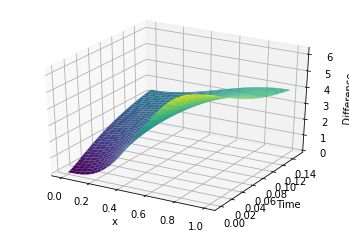

In [5]:
#Generate axes
x = np.outer(x_vec, np.ones(numSolver.timesteps+1))
t = np.outer(np.linspace(0, numSolver.timesteps*k, numSolver.timesteps+1), np.ones_like(x_vec)).T

#Generate figure objects
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot solution and initial condition
ax.plot_surface(x, t, numSolver.U, cmap='viridis', edgecolor='none', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Time')
ax.set_zlabel('Difference')
plt.show()

We make the reference solution with $M^* = 2^{12} - 1$. This will ensure that we will evaluate in the same points when halving the number of points successively

In [6]:
#Numerical parameters
M=2**12 - 1 #M*+1 = 4096
h=1/(M+1)
k = 1e-5

#Slicing because np.arange can sometimes take one step too much due to rounding errors
x_vec = np.arange(0,1+h,h)[:M+2]

#Initial temperature
U0 = f(x_vec)

#Make solver object
reference = heatEqSolver(M, k, U0)

#Solve
reference.solve("crank", int(np.floor(0.15/k)))

print("Shape of reference solution: ", reference.U.shape)

Calculation using crank done.           Elapsed time: 102 seconds                                                       
Shape of reference solution:  (4097, 15000)


We plot the reference solution. Note that this is massive, so we only plot every 100th timestep and every 32nd spacial step

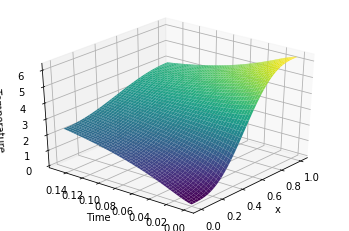

In [7]:
#Generate axes
x = np.outer(x_vec[::32], np.ones(reference.timesteps//100+1))
t = np.outer(np.linspace(0, reference.timesteps*k, reference.timesteps//100+1), np.ones_like(x_vec[::32])).T

#Generate figure objects
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot solution and initial condition
ax.plot_surface(x, t, reference.U[::32,::100], cmap='viridis', edgecolor='none', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.view_init(32, -141)
plt.show()

We then test how the solver works with a course grid

Calculation using be done.           Elapsed time: 0 seconds                                                       


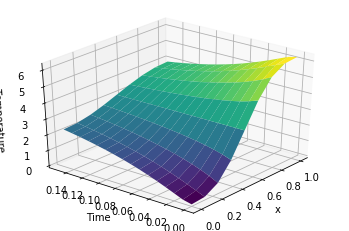

In [8]:
#Numerical parameters
M=2**3 - 1
h=1/(M+1)
k = 1e-2

#Slicing because np.arange can sometimes take one step too much due to rounding errors
x_vec = np.arange(0,1+h,h)[:M+2]

#Initial temperature
U0 = f(x_vec)

#Make solver object
test = heatEqSolver(M, k, U0)

#Solve
test.solve("be", int(np.floor(0.15/k)))

#Generate axes
x = np.outer(x_vec, np.ones(test.timesteps+1))
t = np.outer(np.linspace(0, test.timesteps*k, test.timesteps+1), np.ones_like(x_vec)).T

#Generate figure objects
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot solution and initial condition
ax.plot_surface(x, t, test.U, cmap='viridis', edgecolor='none', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.view_init(32, -141)
plt.show()

Make the list of Ms we want to test

In [9]:
#The Ms we want to use when refining
Ms = np.logspace(4, 10, 7, base=2, dtype=np.intc) - 1

errorsEuler = np.zeros(Ms.shape)
errorsCrank = np.zeros(Ms.shape)

print(Ms)

[  15   31   63  127  255  511 1023]


Perform the UMR

In [10]:
beep = time.time()
for i, m in enumerate(Ms):
    h=1/(m+1)
    k = 1e-5
    
    #Compute number of timesteps needed to get us to time t*
    n = int(np.floor(0.15/k))
    
    #Set up xaxis and inital condition
    x_vec = np.arange(0,1+h,h)[:m+2]
    U0 = f(x_vec)
    
    #In order to evaluate the reference solution and the numerical solution at the same x-points, we need
    #to step over some points in the reference solution
    step = int(2**((np.log2(reference.U.shape[0]) - np.log2(Ms[0]+1))-i))
    
    #Solve using Backwards Euler
    numSolver = heatEqSolver(m, k, U0)
    numSolver.solve("be", n, M = m)
    errorsEuler[i] = np.sqrt(1/(m+2)*np.sum((reference.U[::step, -1] - 
                                        numSolver.U[:, -1])**2))/np.sqrt((1/(m+2)*np.sum(reference.U[::step, -1]**2)))
    
    #Solve using Crank-Nicolson
    numSolver = heatEqSolver(m, k, U0)
    numSolver.solve("crank", n, M=m)
    errorsCrank[i] = np.sqrt(1/(m+2)*np.sum((reference.U[::step, -1] - 
                                        numSolver.U[:, -1])**2))/np.sqrt((1/(m+2)*np.sum(reference.U[::step, -1]**2)))

print("Total time: ", time.time()-beep)

Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 1 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 2 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 2 seconds                                                       
Calculation using be done.           Elapsed time: 1 seconds                                                       
Calculation using crank done.           Elapsed time: 5 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds

Plot results

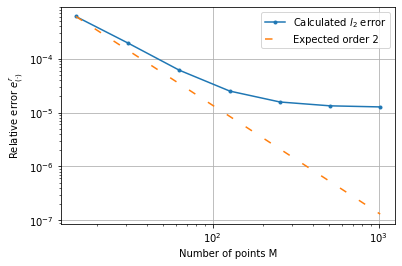

Average order for backwards Euler:  0.9153728905878279


In [11]:
plt.loglog(Ms, errorsEuler, label = "Calculated $l_2$ error", marker = ".")
plt.loglog(*expectedOrder(Ms[0], Ms[-1], errorsEuler[0], 2), linestyle = (0, (5,10)), label="Expected order 2")
plt.xlabel("Number of points M")
plt.ylabel("Relative error $e_{(\cdot)}^{r}$")
plt.grid()
plt.legend()
plt.show()
print("Average order for backwards Euler: ", estimateOrder(Ms, errorsEuler))

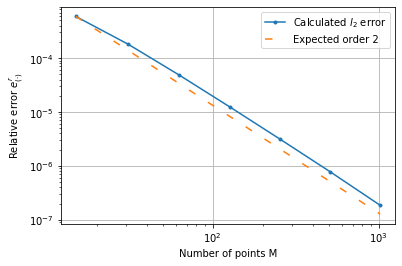

Average order for Crank-Nicolson:  1.9107435934172519


In [12]:
plt.loglog(Ms, errorsCrank, label = "Calculated $l_2$ error", marker = ".")
plt.loglog(*expectedOrder(Ms[0], Ms[-1], errorsCrank[0], 2), linestyle = (0, (5,10)), label="Expected order 2")
plt.xlabel("Number of points M")
plt.ylabel("Relative error $e_{(\cdot)}^{r}$")
plt.grid()
plt.legend()
plt.show()
print("Average order for Crank-Nicolson: ", estimateOrder(Ms, errorsCrank))

## Problem 2b)
First, we test that our implementation actually solve the problem and give the manufactured solution

In [13]:
def analyticSolution(x,t):
    return np.exp(-np.pi**2*t)*np.cos(np.pi*x)

def initfunc(x):
    return np.cos(np.pi*x)

#Numerical parameters
r = 5*100**2 * 1e-5 #This value of r has proven to work well
M=30
h=1/(M+1)

k = 1/20000
timesteps = int(0.5/k)

#Slicing because np.arange can sometimes take one step too much due to rounding errors
x_vec = np.arange(0,1+h,h)[:M+2]

#Initial temperature
U0 = initfunc(x_vec)

numSolver = heatEqSolver(M, k, U0, 0, 0)
numSolver.solve("crank", timesteps) #Select "be" or "crank" for backwards euler or crank-nicolson

#Generate axes
x = np.outer(x_vec, np.ones(timesteps+1))
t = np.outer(np.linspace(0, timesteps*k, timesteps+1), np.ones_like(x_vec)).T

#Make plots interactive
#%matplotlib notebook


Calculation using crank done.           Elapsed time: 1 seconds                                                       


We plot the manufactured solution

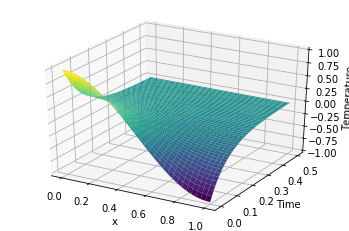

In [14]:
#Generate figure objects
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot analytic solution
ax.plot_surface(x, t, analyticSolution(x,t), cmap='viridis', edgecolor='none', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
plt.show()

We then plot the numerical solution

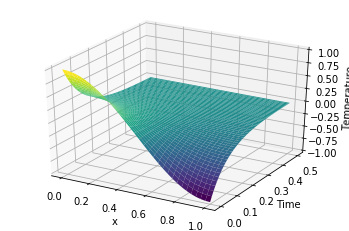

In [15]:
#Generate figure objects
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot numerical solution
ax.plot_surface(x, t, numSolver.U, cmap='viridis', edgecolor='none', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
plt.show()

And finally we can plot the difference between the two

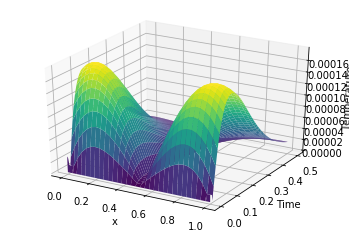

In [16]:
#Generate figure objects
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot solution and initial condition
ax.plot_surface(x, t, np.abs(analyticSolution(x,t)-numSolver.U), cmap='viridis', edgecolor='none', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
plt.show()

Now going to make errorplots for both 1st and 2nd order methods for both l2 and L2 norms. Going to use uniform mesh refinement in both x- and t-direction, where k=ch and r=k/h^2 is constant.

Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 0 seconds         

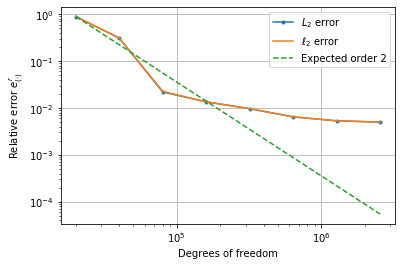

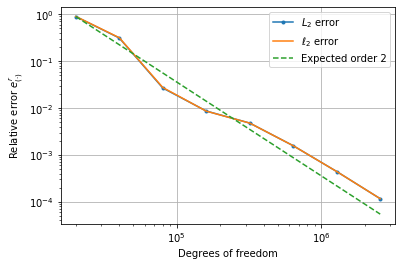

Order of CN with UMR:  1.8437362772333388 



In [17]:
errorPlots(2**1, 2**8, 10000, typ="n-const")

Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds            

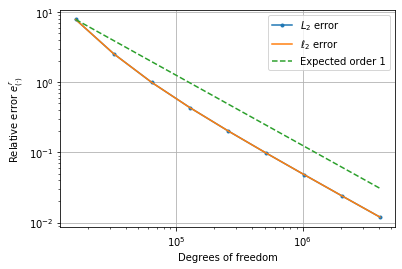

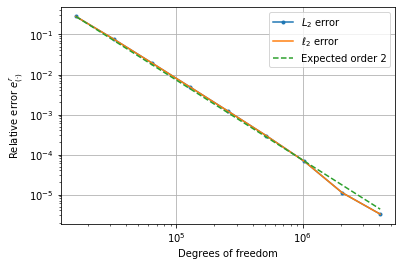

Order of CN with UMR:  2.051486413221288 



In [18]:
errorPlots(2**4, 2**12, typ="m-const", constant=1000)

Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 1 seconds                                                       
Calculation using be done.           Elapsed time: 2 seconds                                                       
Calculation using be done.           Elapsed time: 8 seconds                                                       
Calculation using crank done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 1 seconds                                                       
Calculation using crank done.           Elapsed time: 5 seconds   

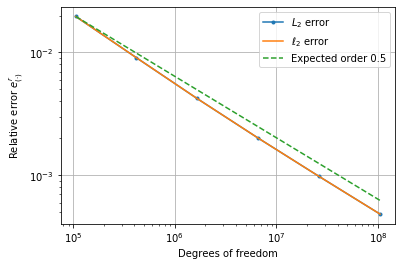

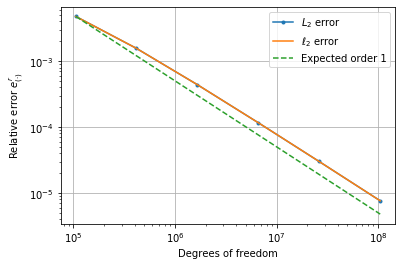

Order of CN with UMR:  0.9325402352395428 



In [19]:
errorPlots(2**5, 2**10, typ="c-const", constant=0.01)

Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using be done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 0 seconds                                                       
Calculation using crank done.           Elapsed time: 0 seconds      

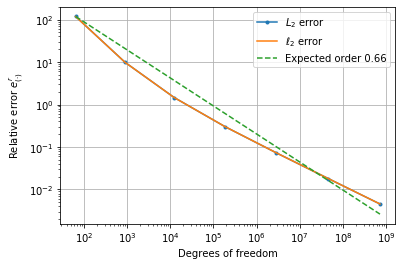

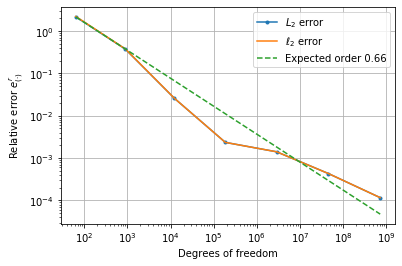

Order of CN with UMR:  0.6048972448220369 



In [20]:
errorPlots(2**2, 2**8, typ="r-const", constant=6)

# Problem 2c)

In [21]:
#Choosing M=1000 internal points and making the uniform grid x_vec.
M=1000
x_axis = np.linspace(0,1,M+2)[1:M+1]

#Solving burgers equation from t=0 to t=0.1 with steplengths 1e-4 in time, and from x=0 to x=1 with steplengths 1e-3 in space
solution_burgers_eq = solve_RK_45(0,0.1,1e-4,f_2c(x_axis))



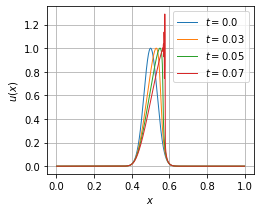

In [22]:
fig, ax = plt.subplots(figsize=(4,3))

plt.subplots_adjust(top=0.949,
bottom=0.174,
left=0.141,
right=0.859,
hspace=0.2,
wspace=0.2)

for i in [0,300,500,700]:
    ax.plot(x_axis,solution_burgers_eq[i], label="$t="+str(i/1e4)+"$", linewidth=1)

ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$")
ax.legend()
ax.grid()
plt.show()

Breaks approximately at time: 0.0598


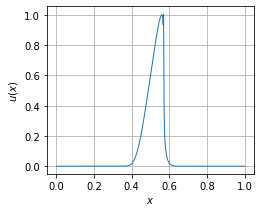

In [23]:
#Finding a point in time close to when the wave breaks
i=0
while True:
    #When the wave starts breaking, its max value no longer is 1. Added small term to account for error in numerical method
    if max(solution_burgers_eq[i])>1 + 1e-3: 
        break
    else:
        i+=1
print("Breaks approximately at time:",i/1e4)

fig, ax = plt.subplots(figsize=(4,3))

plt.subplots_adjust(top=0.949,
bottom=0.174,
left=0.141,
right=0.859,
hspace=0.2,
wspace=0.2)

#Plotting the wave at this time
ax.plot(x_axis,solution_burgers_eq[i], linewidth=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$")
ax.grid()
plt.show()

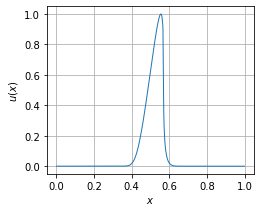

In [24]:
fig, ax = plt.subplots(figsize=(4,3))

plt.subplots_adjust(top=0.949,
bottom=0.174,
left=0.141,
right=0.859,
hspace=0.2,
wspace=0.2)

#Plotting the wave at time t=0.0550
ax.plot(x_axis,solution_burgers_eq[550], linewidth=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$")
plt.grid()
plt.show()

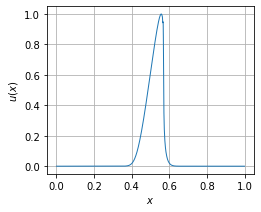

In [25]:
fig, ax = plt.subplots(figsize=(4,3))

plt.subplots_adjust(top=0.949,
bottom=0.174,
left=0.141,
right=0.859,
hspace=0.2,
wspace=0.2)

#Plotting the wave at time t=0.0570
ax.plot(x_axis,solution_burgers_eq[570], linewidth=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$")
plt.grid()
plt.show()

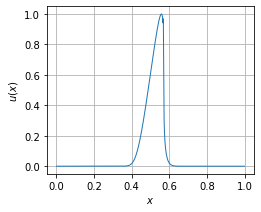

In [26]:
fig, ax = plt.subplots(figsize=(4,3))

plt.subplots_adjust(top=0.949,
bottom=0.174,
left=0.141,
right=0.859,
hspace=0.2,
wspace=0.2)

#Plotting the wave at time t=0.0580
ax.plot(x_axis,solution_burgers_eq[580], linewidth=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$")
plt.grid()
plt.show()

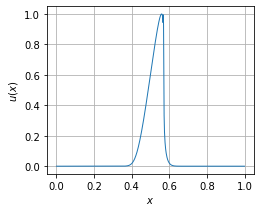

In [27]:
fig, ax = plt.subplots(figsize=(4,3))

plt.subplots_adjust(top=0.949,
bottom=0.174,
left=0.141,
right=0.859,
hspace=0.2,
wspace=0.2)

#Plotting the wave at time t=0.0550
ax.plot(x_axis,solution_burgers_eq[590], linewidth=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$")
plt.grid()
plt.show()